### Calculate size of binary caustic (https://arxiv.org/pdf/astro-ph/0505363)
$\cos{\phi_c} = \dfrac{3}{4}(s + s^{-1})\left(1 - \sqrt{1 - \dfrac{32}{9}(s + s^{-1})^{-2}}\right)$ (Equation 10)

$\Delta\xi_c = \dfrac{4q}{(s - s^{-1})^2}$ (Equation 11)

$\Delta\eta_c = \Delta\xi_c \dfrac{(s - s^{-1})^2|\sin^3{\phi_c}|}{(s + s^{-1} - 2\cos{\phi_c})^2}$ (Equation 12)

### Calculate thickness of annulus from difference in positions of major and minor images
$y_{\pm} = \pm \dfrac{1}{2}(\sqrt{u^2+4} \pm u)$

$t = y_{+} + y_{-} = u$
<!-- \sqrt{u^2 + 4}$// -->

$u \equiv$ farthest point from CM of caustic

Positions of cusps:

$\xi_{c, 0\pm} \approx \pm \dfrac{q}{(1 \pm s)(1 \pm s^{-1})}$

$\eta_{c, 0\pm} \approx \pm \dfrac{2q|\sin^3{\phi_c}|}{(s + s^{-1} - 2\cos{\phi_c})^2}$

In [5]:
import MulensModel as mm
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pyplot as patches

In [17]:
lens_att = [
    [0, 0, 0.01, 1],
    [0.4, 0, 0.01, 0.001]
]

lens_att = np.array(lens_att)

L = np.shape(lens_att)[0]
# total_M = np.sum(lens_att[:, 3])

# CM_sum = 0
# for i in range(L):
#     CM_sum += lens_att[i, :2] * lens_att[i, 3]

# lens_CM = CM_sum / total_M

# lens_att[:, :2] = lens_att[:, :2] - lens_CM

lens_CMs = np.zeros(shape=(L, 2))
for i in range(1, L):
    print(i)
    q = lens_att[i, -1]
    s = lens_att[i, 0]

    lens_CMs[i, 0] = q * s / (1 + q)

print(lens_att)
print(lens_CMs)

1
[[0.    0.    0.01  1.   ]
 [0.4   0.    0.01  0.001]]
[[0.        0.       ]
 [0.0003996 0.       ]]


In [ ]:
def calc_size_caustic(i, q, s):
    '''
    Calculating the size of the central caustic.
    '''
    cos_phi_c = 3/4 * (s + s**-1) * (1 - np.sqrt(1 - 32/9*(s + s**-1)**-2))
    print('cos(phi_c):', cos_phi_c)
    phi_c = np.arccos(cos_phi_c)
    print('phi_c:', phi_c)

    height = 4*q / (s - s**-1)**2

    width = height * ((s - s**-1)**2 * np.abs(np.sin(phi_c)**3)) / (s + s**-1 - 2 * cos_phi_c)**2

    x_pos = q / ((1 + s)*(1 + s**-1)) - lens_CMs[i+1, 0]
    x_neg = -q / ((1 - s)*(1 - s**-1)) - lens_CMs[i+1, 0]

    print('xi_c,0+:', x_pos)
    print('xi_c,0-:', x_neg)

    y_pos = (2*q * np.abs(np.sin(phi_c)**3)) / (s + s**-1 - 2*cos_phi_c)**2 - lens_CMs[i+1, 1]
    y_neg = -(2*q * np.abs(np.sin(phi_c)**3)) / (s + s**-1 - 2*cos_phi_c)**2 - lens_CMs[i+1, 1]

    return width, height, [x_neg, x_pos, y_pos*np.tan(phi_c - np.pi/2), y_neg, y_pos]

In [12]:
def calc_mm_points(i, lens_att):
    # Finding which index the bigger mass was passed in (primary lens)
    big_mass = np.where(lens_att[:, 3] == np.max(lens_att[:, 3]))[0][0]

    # Secondary lens
    small_mass = int(not big_mass)

    # Defining unit source vector
    uhat = [1, 0]

    # Defining unit binary axis vector (from primary to secondary lens)
    v = [lens_att[small_mass, 0] - lens_att[big_mass, 0], lens_att[small_mass, 1] - lens_att[big_mass, 1]]
    vhat = v / np.linalg.norm(v)

    # Finding counterclockwise angle between binary axis and source trajectory (alpha)
    if vhat[0] > 0 and vhat[1] > 0:
        alpha = np.arctan(vhat[1]/vhat[0])
    elif vhat[0] < 0 and vhat[1] > 0:
        alpha = np.pi + np.arctan(vhat[1]/vhat[0])
    elif vhat[0] < 0 and vhat[1] < 0:
        alpha = np.pi + np.arctan(vhat[1]/vhat[0])
    elif vhat[0] > 0 and vhat[1] < 0:
        alpha = np.arctan(vhat[1]/vhat[0])
    elif vhat[0] > 0 and vhat[1] == 0:
        alpha = 0
    elif vhat[0] == 0 and vhat[1] > 0:
        alpha = np.pi/2
    elif vhat[0] < 0 and vhat[1] == 0:
        alpha = np.pi
    elif vhat[0] == 0 and vhat[1] < 0:
        alpha = -np.pi/2

    # Calculating distance between lenses (s)
    s = np.linalg.norm(v)

    # Calculating mass ratio between lenses (q)
    q = lens_att[small_mass, 3] / lens_att[big_mass, 3]

    # Initializing MulensModel Caustics class
    model = mm.Caustics(q=q, s=s)

    # Initializing parameter dictionary
    param_dict = {'q': q, 's': s, 'alpha': alpha}

    # Retrieving x and y points of caustics
    caustic_points = np.array(model.get_caustics(n_points=5000)).transpose()

    # Creating rotation matrix (to rotate caustic points into correct binary axis)
    cos, sin = np.cos(alpha), np.sin(alpha)
    Rot = np.array([[cos, -sin], [sin, cos]])

    # Initializing array of rotated caustic points (2x5000)
    rotated_caustic_points = np.zeros(shape=np.shape(caustic_points))

    # Calculating dot product of rotation matrix and each position calculated by MulensModel
    for ii, pos in enumerate(caustic_points):
        rotated_caustic_points[ii] = np.dot(Rot, pos)

    # Extracting array of x and array of y values
    mm_x = rotated_caustic_points.transpose()[0]
    mm_y = rotated_caustic_points.transpose()[1]

    width, height, cusp_points = calc_size_caustic(i, q, s)

    return mm_x, mm_y, alpha, width, height, cusp_points

cos(phi_c): 0.522539713033926
phi_c: 1.0209693518160388
xi_c,0+: -0.0001955187669473384
xi_c,0-: 0.0007115107115107117


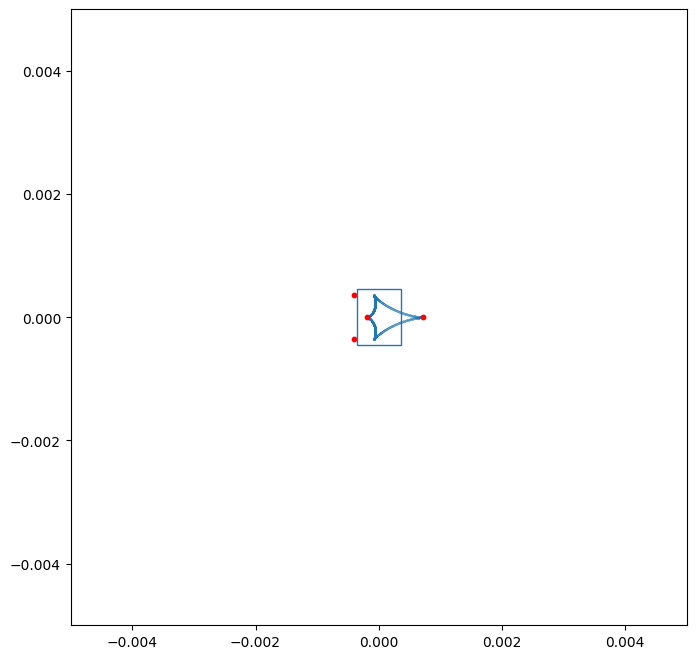

In [16]:
mm_x_list = np.zeros((5000, len(lens_att) - 1))
mm_y_list = np.zeros((5000, len(lens_att) - 1))
alphas = np.zeros(len(lens_att) - 1)
rectangle_list = []
cusp_points_x_list = []
cusp_points_y_list = []

default_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot()

for i, lens in enumerate(lens_att[1:]):
    two_lenses = np.array([lens_att[0], lens])
    mm_x_list[:, i], mm_y_list[:, i], alphas[i], width, height, cusp_points = calc_mm_points(i, two_lenses)
    
    cusp_points_x_list.append([cusp_points[0], cusp_points[1], cusp_points[2], cusp_points[2]])
    cusp_points_y_list.append([0, 0, cusp_points[3], cusp_points[4]])

    bounding_box = patches.Rectangle((-width/2, -height/2), width, height, facecolor='none', edgecolor=default_colors[i], angle=np.rad2deg(alphas[i]), rotation_point=(0, 0))

    rectangle_list.append(bounding_box)

for i, rectangle in enumerate(rectangle_list):
    ax.scatter(mm_x_list[:, i], mm_y_list[:, i], s=0.01, alpha=1, c=default_colors[i])
    ax.scatter(cusp_points_x_list[i], cusp_points_y_list[i], s=10, c='red')
    ax.add_patch(rectangle)

bound = 0.005
ax.set_xlim(-bound, bound)
ax.set_ylim(-bound, bound)
ax.set_aspect('equal')

plt.show()